In [2]:

from scipy.interpolate import griddata

import matplotlib.pyplot  as plt

from matplotlib import cm
from collections import OrderedDict
from colorspacious import cspace_converter
cmaps=OrderedDict()
cmaps['Perceptually Uniform Sequential'] = [
            'viridis', 'plasma', 'inferno', 'magma', 'cividis']

cmaps['Sequential'] = [
            'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
cmaps['Sequential (2)'] = [
            'binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink',
    
            'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia',
            'hot', 'afmhot', 'gist_heat', 'copper']

cmaps['Diverging'] = [
            'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
            'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']

cmaps['Miscellaneous'] = [
            'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg',
            'gist_rainbow', 'rainbow', 'jet', 'turbo', 'nipy_spectral',
            'gist_ncar']

###Les données 

import tensorflow as tf
import numpy as np
import scipy.io
import time
import sys
import os
from tensorflow import keras







#path_data = '/media/delcey1/Elements/these/GRAVITY_CURRENTS/DATA/DATA_20_04/run_200_450_piv0.mat'
path_data = '/media/delcey1/Elements/these/GRAVITY_CURRENTS/DATA/DATA_20_04/data_pas_1_23_04.mat'
def data_regression_rho(path_data,t1,t2,proportion):
    data = scipy.io.loadmat(path_data)
    t_star = data['t'].reshape([-1,1])[t1:t2]# T x 1
    x_star = data['x'][:,t1:t2] # N x 1
    y_star = data['y'][:,t1:t2] # N x 1

    
    T = t_star.shape[0]
    print(T)
    N = x_star.shape[0]
    print(N)
    Rho_star = data['Densite'][:,t1:t2]
    T_star = np.tile(t_star, (1,N)).T
    print(T_star.shape)
    X_star = x_star 
    Y_star = y_star 
    T_data = T # int(sys.argv[1])
    N_data = N # int(sys.argv[2])
    ind_t = np.random.randint(T_data,size = T_data)
    ind_x = np.random.randint(N_data, size = int(N_data*proportion))
    print(ind_t.shape)
    t_data = T_star[ind_x, :][:,ind_t].flatten().reshape(-1,1)
    x_data = X_star[ind_x, :][:,ind_t].flatten().reshape(-1,1)
    y_data = Y_star[ind_x, :][:,ind_t].flatten().reshape(-1,1)
    rho_data = Rho_star[ind_x, :][:,ind_t].flatten().reshape(-1,1)
    
    return t_data,x_data,y_data,rho_data

t_data, x_data, y_data, rho_data = data_regression_rho(path_data,0,300,1.0)
inp_grad=np.concatenate([x_data,y_data,t_data],1)
inp_train = inp_grad

data_X = [inp_grad,inp_train]
data_Y = [rho_data]

300
15353
(15353, 300)
(300,)


In [ ]:
###Validation 

In [2]:
data_Y[0].shape


(2302950, 1)

In [2]:
import tensorflow as tf
import tensorflow_addons as tfa

In [3]:

class HFM_keras(tf.keras.Model):
    
    def __init__(self,num_layers,num_units,alpha=1,paths={'rho':None,'u':None,'v':None,'p':None}):
 

        
        super(HFM_keras, self).__init__()
        
        visc=4e-3 
        eta = 1e-9
        g=9.81
        rho_0=1002.4
        ##Les constantes
        self.visc = visc
        self.eta = eta
        self.g = g 
        self.rho_0 = rho_0
        self.grad_input = None
        self.alpha = alpha
        
        
        ##paths 
        self.mod_rho_path = paths['rho']
        self.mod_u_path = paths['u']
        self.mod_v_path = paths['v']
        self.mod_p_path = paths['p']
        
        #Le réseau
        self.num_units = num_units
        self.num_layers = num_layers
        self.layers_rho = []
        self.layers_u = []
        self.layers_v = []
        self.layers_p = []

        
        num_layer_rho = num_layers['rho']
        num_layer_u= num_layers['u']
        num_layer_v= num_layers['v']
        num_layer_p = num_layers['p']
        
        num_units_rho = num_units['rho']
        num_units_u= num_units['u']
        num_units_v= num_units['v']
        num_units_p = num_units['p']
        
        
        if self.mod_rho_path is None:
            for i in range(num_layer_rho):
                self.layers_rho.append(keras.layers.BatchNormalization())
                hidden = keras.layers.Dense(num_units_rho,activation = 'elu',dtype = tf.float32)
                self.layers_rho.append(hidden)
            self.layers_rho.append(keras.layers.Dense(1))
            self.model_rho = keras.models.Sequential(self.layers_rho,name = 'Model Rho')
        else:
            self.model_rho = keras.models.load_model(self.mod_rho_path)
            
            
        if self.mod_u_path is None:
            for i in range(num_layer_u):
                hidden_u = keras.layers.Dense(num_units_u,activation = 'swish',dtype = tf.float32)
                self.layers_u.append(hidden_u)
            self.layers_u.append(keras.layers.Dense(2))
            self.model_u = keras.models.Sequential(self.layers_u,name = 'Model U')
        else:
            self.model_uv = keras.models.load_model(self.mod_u_path)
            
            
        if self.mod_v_path is None:
            for i in range(num_layer_v):
                hidden_v = keras.layers.Dense(num_units_v,activation = 'swish',dtype = tf.float32)
                self.layers_v.append(hidden_v)
            self.layers_v.append(keras.layers.Dense(2))
            self.model_v = keras.models.Sequential(self.layers_v,name = 'Model V')
        else:
            self.model_v = keras.models.load_model(self.mod_v_path)
            
        if self.mod_p_path is None:
            for i in range(num_layer_p):
                hidden_p = keras.layers.Dense(num_units_p,activation = 'swish',dtype = tf.float32)
                self.layers_p.append(hidden_p)
            self.layers_p.append(keras.layers.Dense(1))
            self.model_p = keras.models.Sequential(self.layers_p,name = 'Model P')
        else:
            self.model_p = keras.models.load_model(self.mod_p_path)
            
        
        print('réseaux créés')

        
    
    
    

                
    def call(self, inputs):
        return self.model_(inputs)
   
        

    
    def compute_duvp_eq(self,inputs):
        visc = self.visc
        g = self.g
        eta = self.eta
        rho_0 = self.rho_0
        x = tf.convert_to_tensor(inputs[:,0:1], dtype=tf.float32)
        y = tf.convert_to_tensor(inputs[:,1:2], dtype=tf.float32)
        t = tf.convert_to_tensor(inputs[:,2:], dtype=tf.float32)
        with tf.GradientTape(persistent =True) as t2:
            t2.watch(x)
            t2.watch(y)
            t2.watch(t)
            with tf.GradientTape(persistent = True) as t1 :
                t1.watch(x)
                t1.watch(y)
                t1.watch(t)
                X = tf.stack([x[:,0],y[:,0],t[:,0]],axis = 1 )
                
                ##Rho
                rho = self.model_rho(X,training = False)
                rho = tf.reshape(rho,(-1,1))
                
                ##u
                U = self.model_u(X,training = True)
                u = tf.reshape(U[:,0],(-1,1))
                
                #v
                V = self.model_v(X,training = True)
                v = tf.reshape(V[:,0],(-1,1))
                
                ##p
                
                P = self.model_p(X,training = True ) 
                p = tf.reshape(P,(-1,1))
                

                
                
                ##Les dérivées premières
            rho_x = t1.gradient(rho, x)
            rho_y = t1.gradient(rho, y)
            rho_t = t1.gradient(rho, t)
            u_x = t1.gradient(u, x)
            u_y = t1.gradient(u, y)
            u_t = t1.gradient(u, t)
            v_x= t1.gradient(v, x)
            v_y= t1.gradient(v, y)
            v_t= t1.gradient(v, t)
            p_x = t1.gradient(p, x)
            p_y = t1.gradient(p, y)


            
         
            
        ###les dérivées secondes
        rho_xx=t2.gradient(rho_x, x)
        rho_yy=t2.gradient(rho_y, y)
        u_xx=t2.gradient(u_x, x)
        u_yy=t2.gradient(u_y, y)
        v_xx=t2.gradient(v_x, x)
        v_yy=t2.gradient(v_y, y)
        
        e1 = (rho_0)*(u*u_x+v*u_y+u_t)+p_x-visc*(u_xx+u_yy)
        e2 = (rho_0)*(u*v_x+v*v_y+v_t)+p_y-visc*(v_xx+v_yy)+g*rho
        e3 = u_x + v_y
        e4 = u*rho_x+v*rho_y+rho_t-eta*(rho_xx+rho_yy)
        e5 = Ec_t + divEcp + rho * g * v - visc * diffvisc
  
   
       
         
        return e1,e2,e3,e4,e5
    





    ##Loss
    def grad_loss(self,inp_grad,inp_train):

        e1,e2,e3,e4 = self.compute_duvp_eq(inp_grad)
        error_e1 = tf.reduce_mean(tf.square(e1))
        error_e2 = tf.reduce_mean(tf.square(e2))
        error_e3 = tf.reduce_mean(tf.square(e3))
        error_e4 = tf.reduce_mean(tf.square(e4))

        return [error_e1, error_e2, error_e3, error_e4]
    
    

                              
                              
                              
                    

        

    def predict(self, inputs):
        inputs = tf.convert_to_tensor(inputs,dtype = tf.float32)
        pred = self.model(inputs)
        e1,e2,e3,e4 = self.NavierStokesEquations(inputs)
        return  pred[:,0].numpy(),e1,e2,e3,e4
    
    def random_batch(self,X,y,batch_size = 32):
        idx = np.random.randint(X[0].shape[0],size = batch_size)
        return [tf.convert_to_tensor(inp[idx,:],dtype = tf.float32) for inp in X],\
    [tf.convert_to_tensor(y_[idx,:],dtype = tf.float32) for y_ in y]
    
    
    def print_status_bar(self,iteration, total, loss, metrics=None):
        metrics = " - ".join(["{}: {:.4f}".format(m.name,m.result()) for m in [loss] + (metrics or [])])
        
        end = "" if iteration <total else "\n" 
        
        print("\r{}/{} - ".format(iteration, total) + metrics, end=end ) 
    
        
        
       
    def train(self,X,y,loss_fn,n_epochs,\
              mean_loss = keras.metrics.MeanSquaredError(),metrics = [keras.metrics.MeanSquaredError()],\
              batch_size = 32):
        
        self.loss_values =[]
        

        n_steps = X[0].shape[0]// batch_size +1
        print(n_steps)
        
        lr_star = 10e-6
        lr = lr_start
        optimizer =  keras.optimizers.Adam(lr = lr) 
        #decay = (lr_end/lr_start)**(1/n_steps)
        #optimizer_u = optimizers['u']
        #optimizer_v = optimizers['v']
        #optimizer_p = optimizers['p']
        
        #for X_ in X:
        #    X_ = (X_-np.mean(X_))/np.std(X_)
        for epoch in range(1,n_epochs +1 ):
            
            progbar = keras.utils.Progbar(batch_size * n_steps,width=40, verbose=1, interval=0.05)
            print("Epoch {}/{}".format(epoch + 1, n_epochs))
            for step in range(1,n_steps+1):
                

                
                X_batch,y_batch =self.random_batch(X,y,batch_size=batch_size)
                inp_grad_batch = X_batch[0]
                inp_train_batch = X_batch[1]    
                rho_obs_batch = y_batch[0]
                
                names = ['e1','e2','e3','e4']
                values = []
                
                with tf.GradientTape(persistent = True) as tape:
                    if self.alpha == 0:
                        rho = self.model_(inp_train_batch,training = True)
                        loss = tf.reduce_mean(tf.square(rho-rho_obs_batch))
                        values = [('loss',loss)]
                    else:
                        #rho = self.model_(inp_train_batch)
                        #loss_rho = tf.reduce_mean(tf.square(rho-rho_obs_batch))
                        #values.append(('loss_rho',loss_rho))
                        list_losses = self.grad_loss(inp_grad_batch,inp_train_batch)
                        loss = 0
                        for ind,loss_ in enumerate(list_losses):
                            loss+= loss_


                            values.append((names[ind],loss_))
                        self.loss_values.append(loss.numpy())
                

                #gradients_rho = tape.gradient(loss_rho,self.model_.trainable_variables)
                gradients = tape.gradient(loss,self.model_u.trainable_variables+\
                                          self.model_v.trainable_variables, unconnected_gradients=tf.UnconnectedGradients.ZERO)
                optimizer.apply_gradients(zip(gradients,self.model_u.trainable_variables+\
                                              self.model_v.trainable_variables+\
                                              self.model_p.trainable_variables))

                progbar.add(batch_size, values=values) 
                if epoch%2==0:
                    self.lr = max(self.lr*decay,1e-6)
            
            

        
   
    
    
    
                
    

            
                
    def predict_step(self,X_test,batch_size):
        n = X_test.shape[0]
        n1 = n//batch_size
        rho_pred = np.zeros((n,1))
        u_pred,v_pred,p_pred =  np.zeros((n,1)), np.zeros((n,1)), np.zeros((n,1))
        for ind in range(n1):
            pred_u = self.model_u(X_test[ind*batch_size:(ind+1)*batch_size,:],training = False)
            pred_v = self.model_v(X_test[ind*batch_size:(ind+1)*batch_size,:],training = False)
            pred_rho =  self.model_rho(X_test[ind*batch_size:(ind+1)*batch_size,:],training = False)
            pred_p =  self.model_p(X_test[ind*batch_size:(ind+1)*batch_size,:],training = False)
            rho_pred_batch=pred_rho[:,0].numpy().reshape(-1,1)
            u_pred_batch=pred_u[:,0].numpy().reshape(-1,1)
            v_pred_batch=pred_v[:,0].numpy().reshape(-1,1)
            p_pred_batch=pred_p[:,0].numpy().reshape(-1,1)
            

            rho_pred[ind*batch_size:(ind+1)*batch_size]=rho_pred_batch
            u_pred[ind*batch_size:(ind+1)*batch_size]=u_pred_batch
            v_pred[ind*batch_size:(ind+1)*batch_size]=v_pred_batch
            p_pred[ind*batch_size:(ind+1)*batch_size]=p_pred_batch
        f_pred_rho = self.model_rho(X_test[(n1-1)*batch_size:,:])
        f_pred_u = self.model_u(X_test[(n1-1)*batch_size:,:])
        f_pred_v = self.model_v(X_test[(n1-1)*batch_size:,:])
        f_pred_p = self.model_p(X_test[(n1-1)*batch_size:,:])

        rho_f_pred = f_pred_rho[:,0].numpy().reshape(-1,1)
        u_f_pred = f_pred_u[:,0].numpy().reshape(-1,1)
        v_f_pred = f_pred_v[:,0].numpy().reshape(-1,1)
        p_f_pred = f_pred_p[:,0].numpy().reshape(-1,1)
        rho_pred[(n1-1)*batch_size:,:]=rho_f_pred
        u_pred[(n1-1)*batch_size:,:]=u_f_pred
        v_pred[(n1-1)*batch_size:,:]=v_f_pred
        p_pred[(n1-1)*batch_size:,:]=p_f_pred
        
        return [rho_pred,u_pred,v_pred,p_pred]
            
                
 

In [4]:
(8/10e-8)**(1/1000)

1.0183641213119454

TypeError: 'NoneType' object is not subscriptable

In [3]:
flow_prop = { 'visc':4e-3, 'eta': 1e-9 , 'g':9.81,'rho_0':999.4}

In [5]:
paths = {'rho':'model_rho_newexp_29_04.hf5','u':None,'v':None,'p':None}

num_layers = {'rho':2,'u':2,'v':2,'p':2}
num_units = {'rho':50,'u':350,'v':350,'p':250}


lr_start = 1e-4

#optimizers = {'rho':keras.optimizers.Adam(lr = lr),\
#              'u':keras.optimizers.Adam(lr = lr),
#              'v':keras.optimizers.Adam(lr = lr),
#              'p':keras.optimizers.Adam(lr = lr)}

optimizer = keras.optimizers.Adam(lr = lr_start) 

In [ ]:
#mod_eqns_path = 'model_eqns_02.hf5'

In [12]:
tf.keras.backend.clear_session()
mod = HFM_keras(num_layers = num_layers,num_units = num_units, alpha=1,paths = paths)

réseaux créés


In [13]:
mod.train(data_X,data_Y,optimizer = optimizer,\
            loss_fn = keras.losses.MeanSquaredError(),n_epochs = 35,batch_size = 4096
          )

598
Epoch 2/35


AttributeError: 'HFM_keras' object has no attribute 'model_'

In [8]:
path_save = '/media/delcey1/Elements/these/Re 2000'
path_save2 = '/home/delcey1/Documents/Re 2000/'
#path_data = '/media/delcey1/Elements/these/GRAVITY_CURRENTS/DATA/DATA_12_04/datafiltre_14_04_200_450_pas_4.mat'
path_data = '/media/delcey1/Elements/these/Re 2000/datafiltre_piv_01.mat'
#path_data = '/media/delcey1/Elements/these/GRAVITY_CURRENTS/DATA/DATA_20_04/data_pred_pas_4_23_04.mat'
l = os.listdir(path_save)

data = scipy.io.loadmat(path_data)

t_star = data['t'].reshape([-1,1])[0:] # T x 1
x_star = data['x'].reshape([-1,1]) # N x 1
y_star = data['y'].reshape([-1,1]) # N x 1



T = t_star.shape[0]
N = x_star.shape[0]
    
    # Rearrange Data 
T_star = np.tile(t_star, (1,N)).T # N x T
X_star = np.tile(x_star, (1,T)) # N x T
Y_star = np.tile(y_star, (1,T)) # N x T




Rho_star = data['Densite'][:,0:]#N x T





In [9]:
t_test = T_star[:,-1].flatten().reshape(-1,1)
x_test = X_star[:,-1].flatten().reshape(-1,1)
y_test = Y_star[:,-1].flatten().reshape(-1,1)
X= np.concatenate([x_test,y_test,t_test],1)
pred = mod.predict_step(X,5000)
[rho_pred,u_pred,v_pred,p_pred]=pred

py,px = data['pixel_xy'][0,0],data['pixel_xy'][0,1]


In [5]:
#mod.model_eqns.save('model_eqns_26_04.hf5')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model_eqns_26_04.hf5/assets


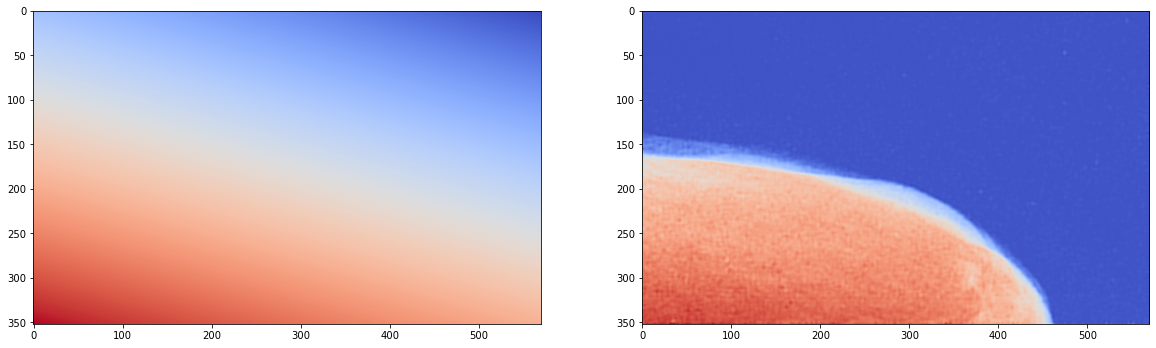

In [11]:
fig, (ax,ax1) =plt.subplots(ncols = 2, figsize = (20,12))
ax.imshow(v_pred.reshape(py,px),cmap = cmaps['Diverging'][9])
ax1.imshow(Rho_star[:,-1].reshape(py,px),cmap = cmaps['Diverging'][9])
plt.show()


In [16]:
list_rho_pred = []
list_u_pred =  []
list_v_pred = []
list_p_pred =  []

for i in range(T_star.shape[1]):
    t_test = T_star[:,i].flatten().reshape(-1,1)
    x_test = X_star[:,i].flatten().reshape(-1,1)
    y_test = Y_star[:,i].flatten().reshape(-1,1)
    X= np.concatenate([x_test,y_test,t_test],1)
    pred = mod.predict_step(X,5000)
    [rho_pred,u_pred,v_pred,p_pred]=pred
    list_rho_pred.append(rho_pred)
    list_u_pred.append(u_pred)
    list_v_pred.append(v_pred)
    list_p_pred.append(p_pred)


py,px = data['pixel_xy'][0,0],data['pixel_xy'][0,1]


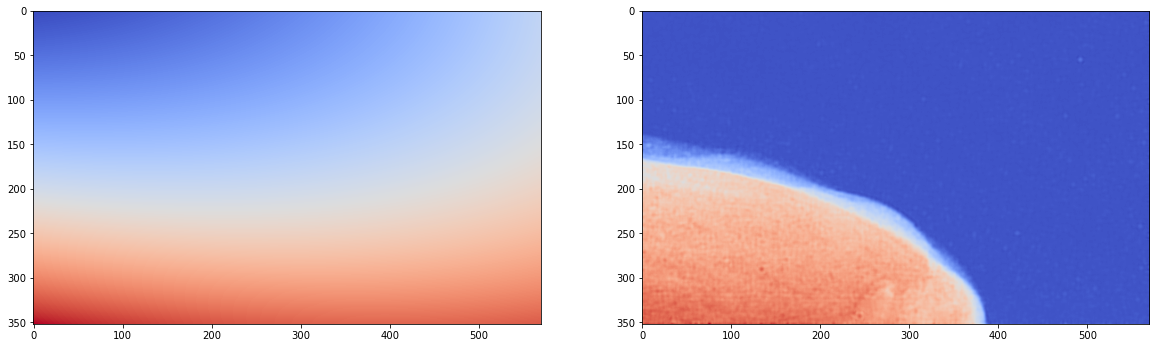

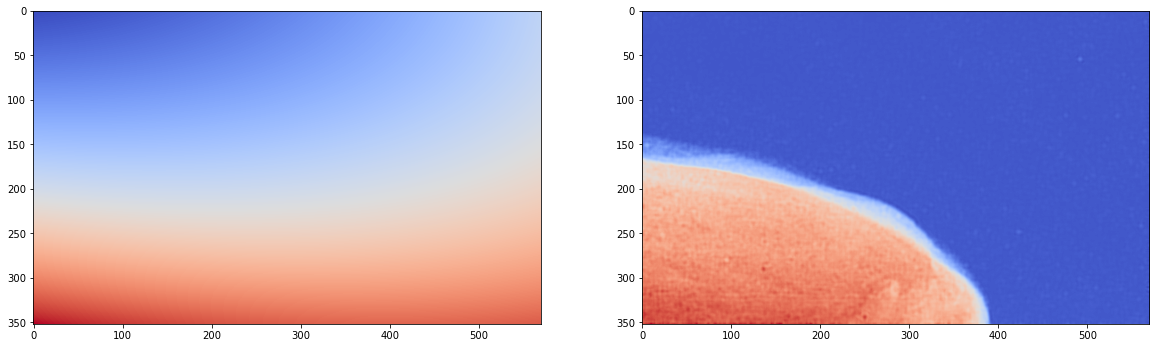

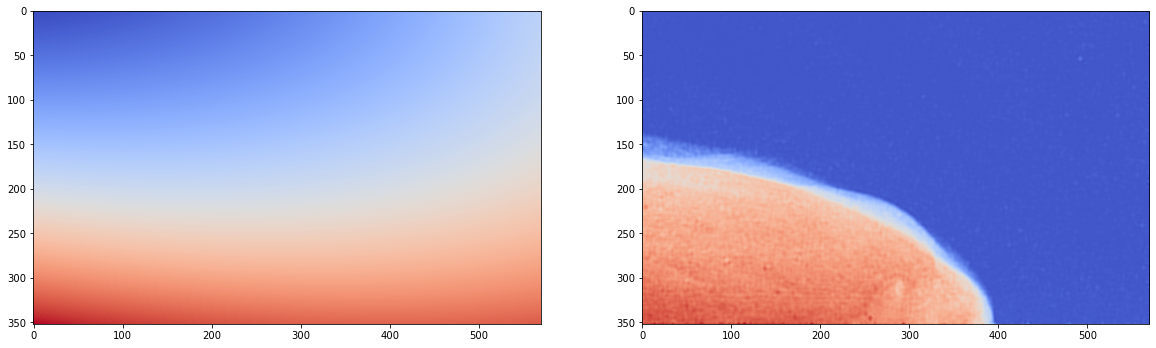

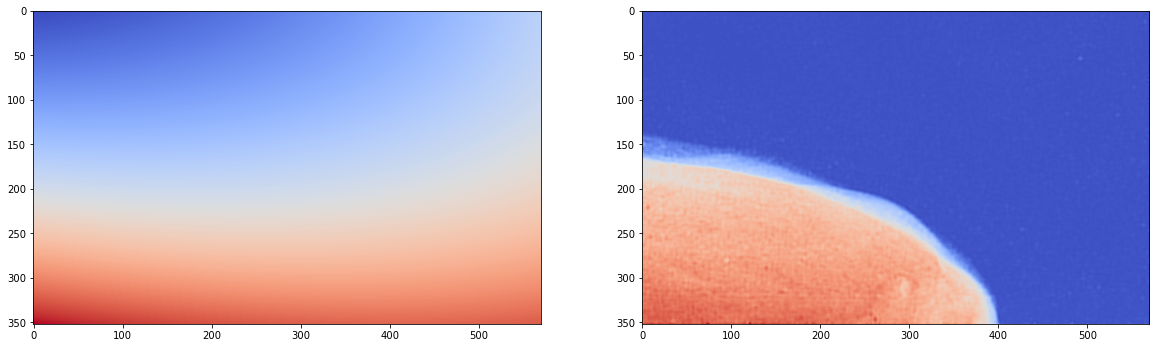

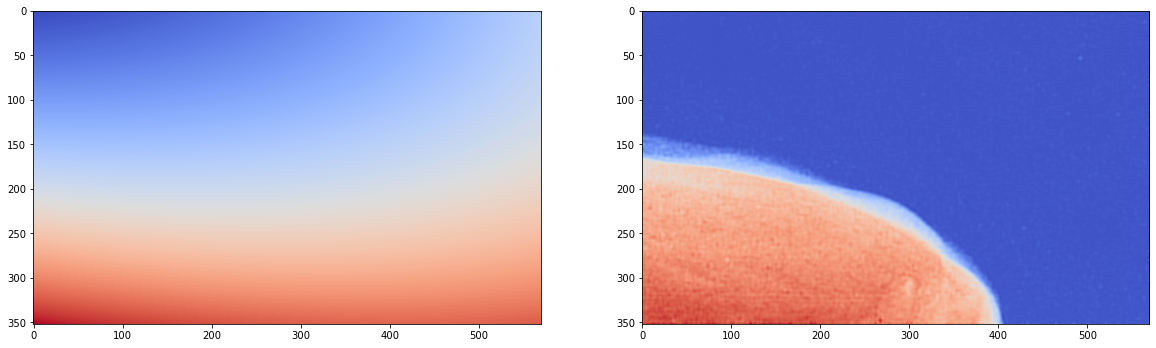

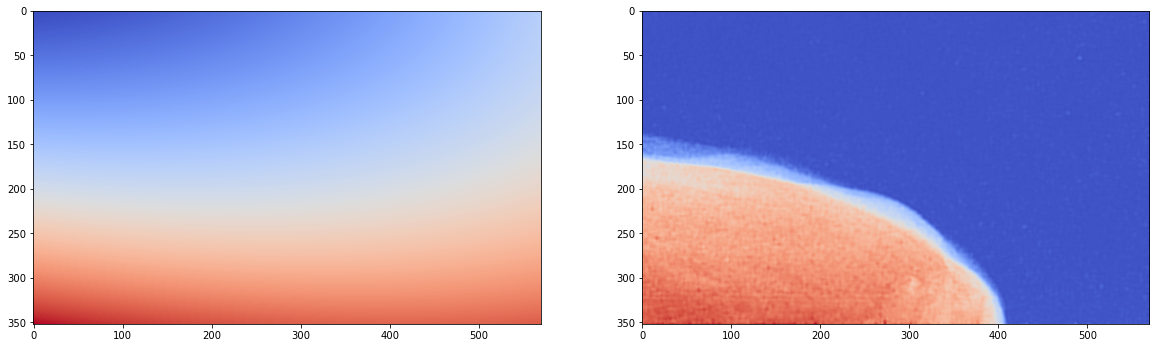

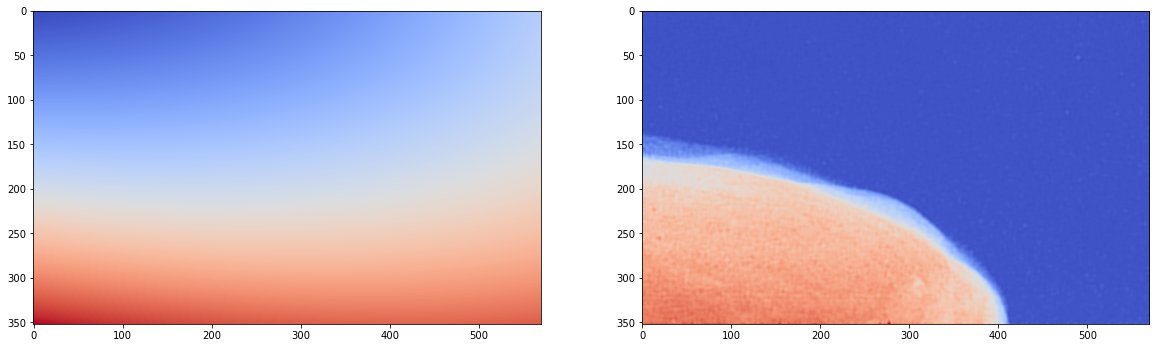

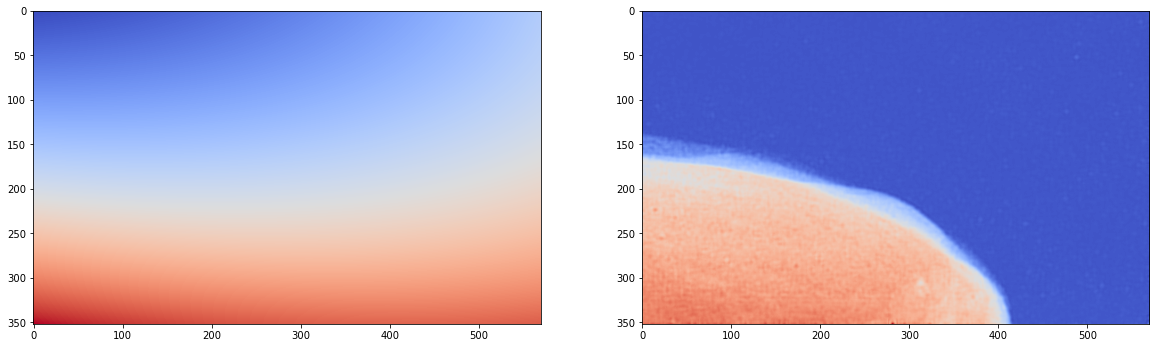

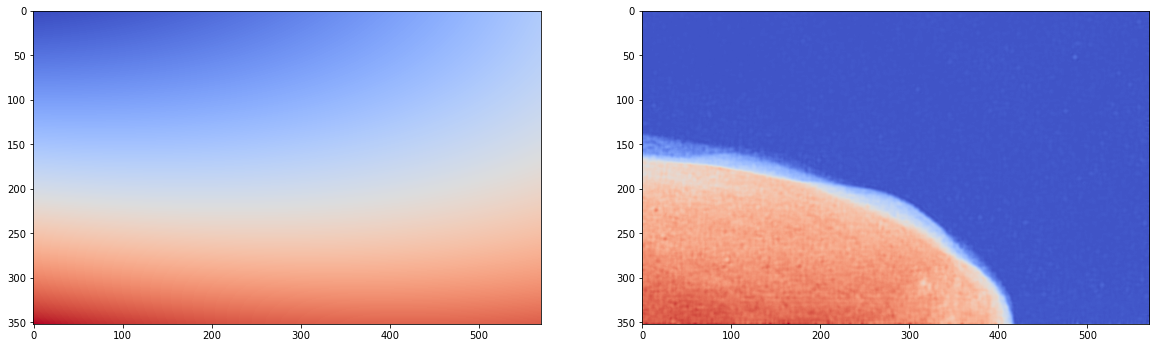

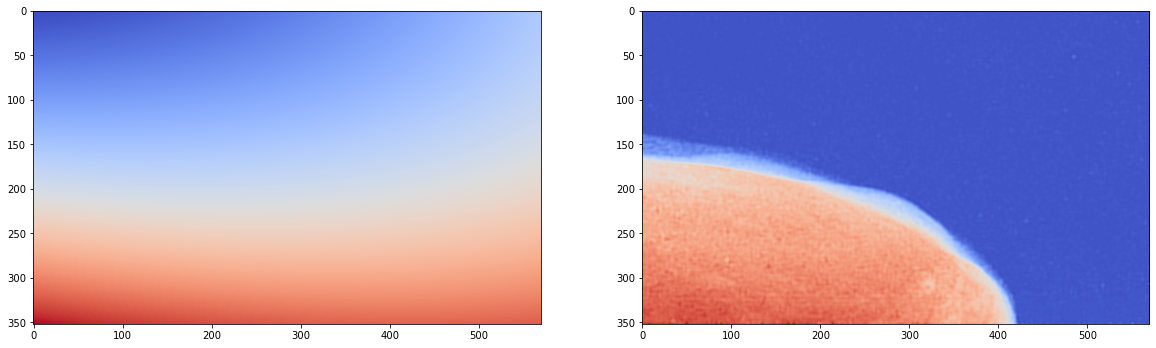

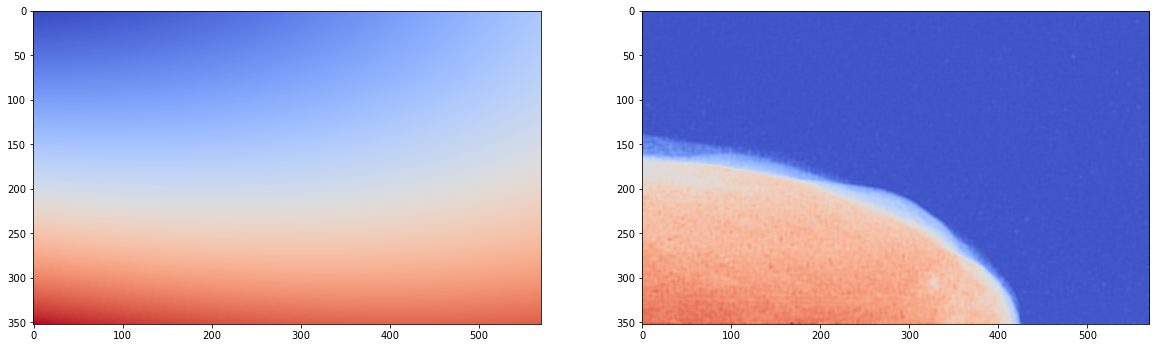

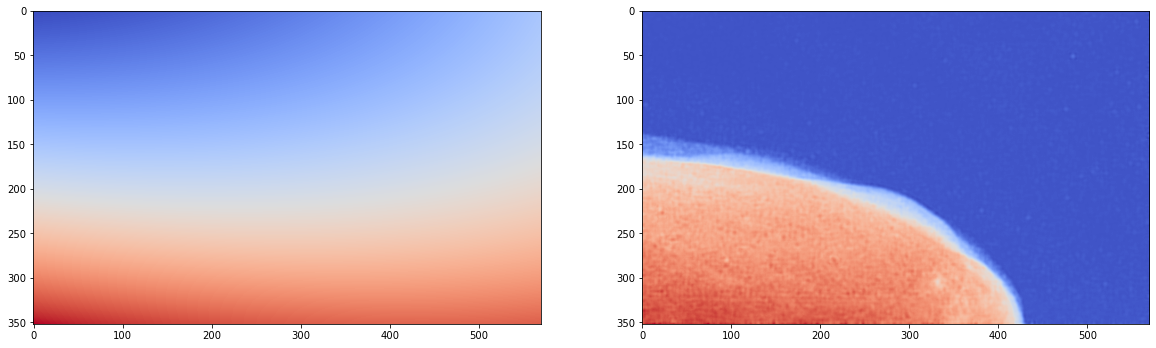

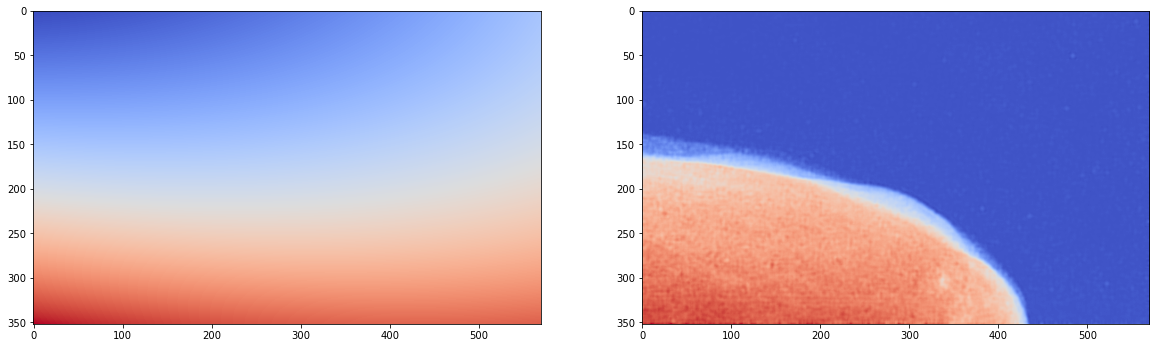

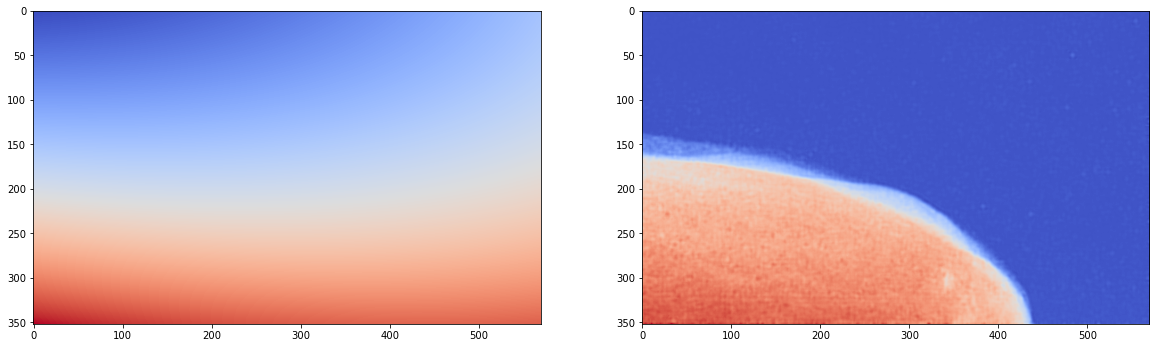

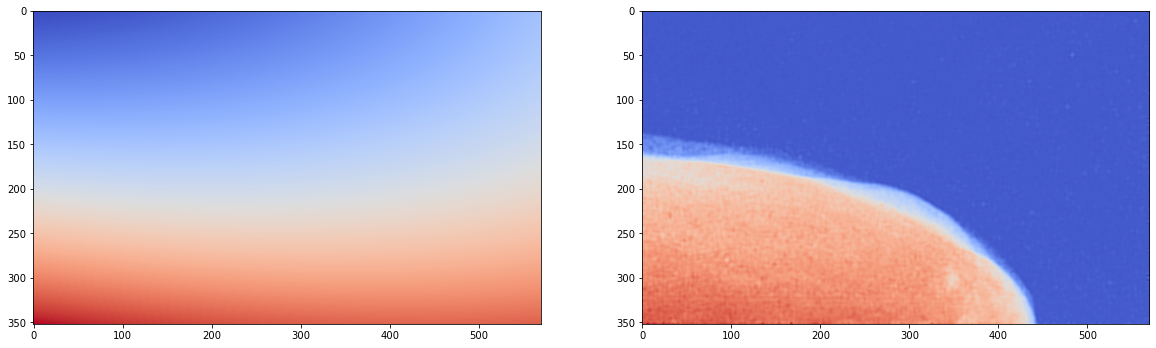

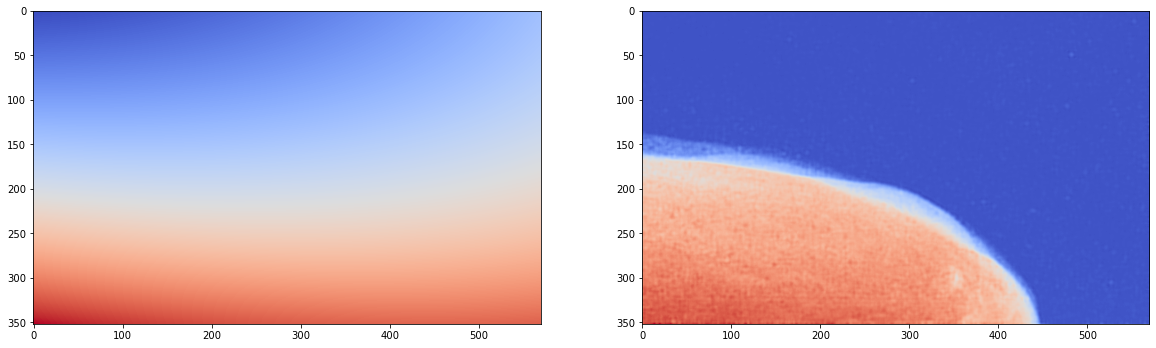

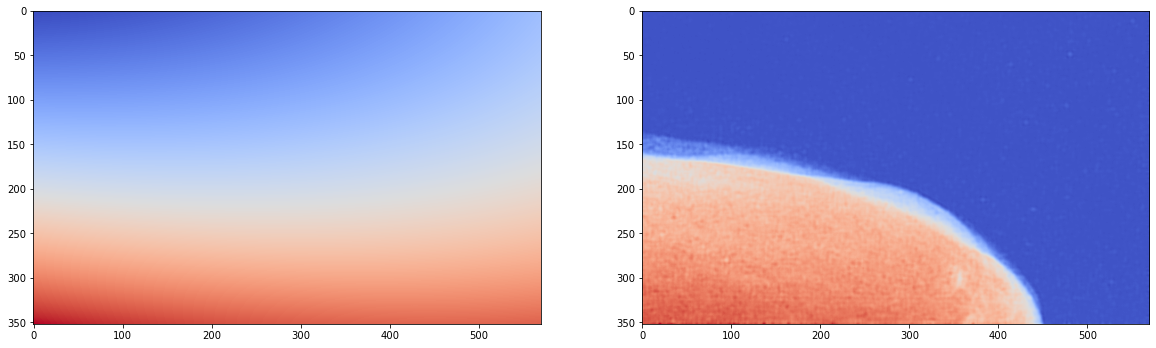

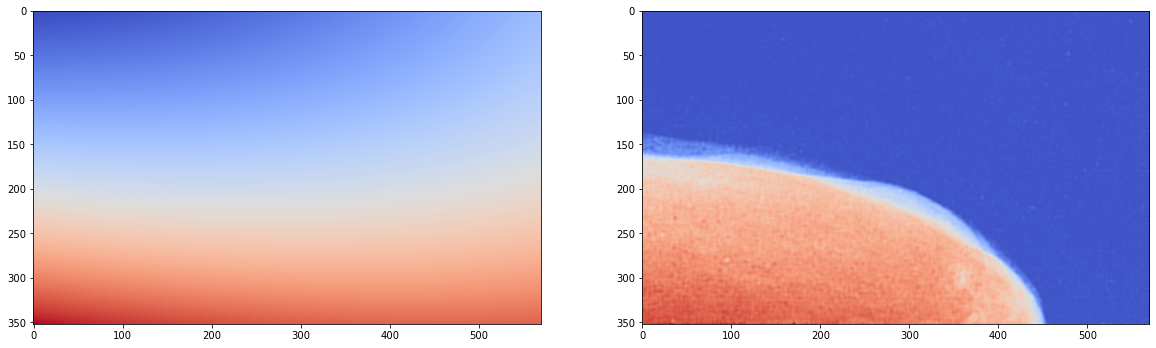

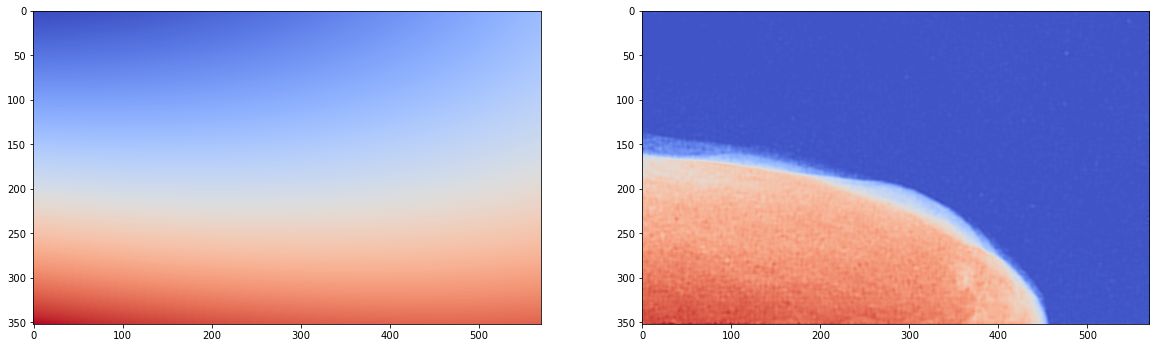

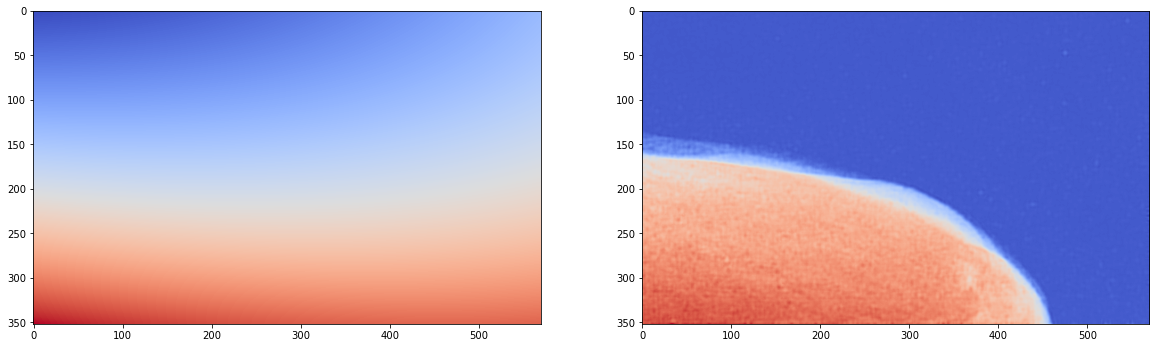

In [19]:
for i in range(200,T_star.shape[1],2):
    fig, (ax,ax1) =plt.subplots(ncols = 2, figsize = (20,12))
    ax.imshow(list_p_pred[i].reshape(py,px),cmap = cmaps['Diverging'][9])
    ax1.imshow(Rho_star[:,i].reshape(py,px),cmap = cmaps['Diverging'][9])
    plt.show()
